In [31]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import print_function
import argparse
import os

import numpy as np
import pickle

from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense, Dropout
from keras.layers import merge
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import list_pictures, array_to_img

from image_ext import list_pictures_in_multidir, load_imgs_asarray
from create_fcn import create_fcn01, create_pupil_net00

np.random.seed(2016)

In [32]:
def load_fnames(paths):
    f = open(paths)
    data1 = f.read()
    f.close()
    lines = data1.split('\n')
    #print(len(lines))
    # 最終行は空行なので消す
    del(lines[len(lines)-1])
    #print(len(lines))
    return lines

In [33]:
def make_fnames(fnames,fpath,fpath_mask,mask_ext):
    fnames_img = [];
    fnames_mask= [];
    
    for i in range(len(fnames)):
        fnames_img.append(fpath + '/' + fnames[i]);
        fnames_mask.append(fpath_mask + '/' + mask_ext + fnames[i]);
        
    return [fnames_img,fnames_mask]

In [34]:
def get_center(im):
    im[im>0] = 1;
    xval = 0
    yval = 0
    npix = 0

    for x in range(0,im.shape[1]):
        xval += (x*sum(im[:,x]))
        npix += sum(im[:,x])
    
    for y in range(0,im.shape[0]):
        yval += (y*sum(im[y,:]))
    
    return [xval/npix,yval/npix]

In [36]:
#
#  MAIN STARTS FROM HERE
#
if __name__ == '__main__':
    
    target_size = (224, 224)
    dpath_this = './'
    dname_checkpoints = 'checkpoints_pupil_net00.augumented.woInitialize'
    dname_checkpoints_fcn01 = 'checkpoints_fcn01'
    dname_outputs = 'outputs'
    fname_architecture = 'architecture.json'
    fname_weights = "model_weights_{epoch:02d}.h5"
    fname_stats = 'stats01.npz'
    dim_ordering = 'channels_first'
    fname_history = "history.pkl"

    # definision of mode, LEARN or TEST or SHOW_HISTORY
    mode = "LEARN"
    mode = "SHOW_HISTORY"
    mode = "TEST"

    # モデルを作成
    print('creating model...')
    model_pupil_net = create_pupil_net00(target_size)
    
    if os.path.exists(dname_checkpoints) == 0:
        os.mkdir(dname_checkpoints)    

creating model...


In [37]:
#
#   LEARNING MODE
#
mode = "LEARN"
if mode == "LEARN":
    # Read Learning Data
    fnames = load_fnames('data_augumented/list_train_01.txt')
    [fpaths_xs_train,fpaths_ys_train] = make_fnames(fnames,'data_augumented/img','data_augumented/mask','')

    X_train = load_imgs_asarray(fpaths_xs_train, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    Y_train = load_imgs_asarray(fpaths_ys_train, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering) 

    # Read Validation Data
    fnames = load_fnames('data_augumented/list_valid_01.txt')
    [fpaths_xs_valid,fpaths_ys_valid] = make_fnames(fnames,'data_augumented/img','data_augumented/mask','')
    
    print('reading validation data')
    X_valid = load_imgs_asarray(fpaths_xs_valid, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    Y_valid = load_imgs_asarray(fpaths_ys_valid, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering)      

    # obtain center of pupil
    center_train = []
    center_valid = []
    
    for i in range(Y_train.shape[0]):
        center_train.append(get_center(Y_train[i,0,:,:]))

    for i in range(Y_valid.shape[0]):
        center_valid.append(get_center(Y_valid[i,0,:,:]))
    
    center_train = np.array(center_train)
    center_valid = np.array(center_valid)

    print('==> ' + str(len(X_train)) + ' training images loaded')
    print('==> ' + str(len(Y_train)) + ' training masks loaded')
    print('==> ' + str(len(X_valid)) + ' validation images loaded')
    print('==> ' + str(len(Y_valid)) + ' validation masks loaded')

    # 前処理
    print('computing mean and standard deviation...')
    mean = np.mean(X_train, axis=(0, 2, 3))
    std = np.std(X_train, axis=(0, 2, 3))
    print('==> mean: ' + str(mean))
    print('==> std : ' + str(std))

    print('saving mean and standard deviation to ' + fname_stats + '...')
    stats = {'mean': mean, 'std': std}
    if os.path.exists(dname_checkpoints) == 0:
        os.mkdir(dname_checkpoints)
    np.savez(dname_checkpoints + '/' + fname_stats, **stats)
    print('==> done')

    print('globally normalizing data...')
    for i in range(3):
        X_train[:, i] = (X_train[:, i] - mean[i]) / std[i]
        X_valid[:, i] = (X_valid[:, i] - mean[i]) / std[i]
    Y_train /= 255
    Y_valid /= 255
    print('==> done')

reading validation data
==> 7800 training images loaded
==> 7800 training masks loaded
==> 1196 validation images loaded
==> 1196 validation masks loaded
computing mean and standard deviation...
==> mean: [125.60018   90.205666  77.57043 ]
==> std : [61.01421  47.890713 51.63054 ]
saving mean and standard deviation to stats01.npz...
==> done
globally normalizing data...
==> done


In [38]:
    fcn00_initialization = 0
    if fcn00_initialization == 1:
        # モデルに学習済のfcn01 Weightをロードする
        epoch = 100
        fname_weights = 'model_weights_%02d.h5'%(epoch)
        model_fcn01 = create_fcn01(target_size)
        fpath_weights_fcn01 = os.path.join(dname_checkpoints_fcn01, fname_weights)
        model_fcn01.load_weights(fpath_weights_fcn01)

        # load weights from Learned U-NET
        layer_names = ['conv1_1','conv1_2','conv2_1','conv2_2']

        print('copying layer weights')
        for name in layer_names:
            print(name)
            model_pupil_net.get_layer(name).set_weights(model_fcn01.get_layer(name).get_weights())
            model_pupil_net.get_layer(name).trainable = True

In [39]:
    # 損失関数，最適化手法を定義
    adam = Adam(lr=1e-5)
    model_pupil_net.compile(optimizer=adam, loss='mean_squared_error')

    # 構造・重みを保存するディレクトリーの有無を確認
    dpath_checkpoints = os.path.join(dpath_this, dname_checkpoints)
    if not os.path.isdir(dpath_checkpoints):
        os.mkdir(dpath_checkpoints)

    # 重みを保存するためのオブジェクトを用意
    fname_weights = "model_weights_{epoch:02d}.h5"
    fpath_weights = os.path.join(dpath_checkpoints, fname_weights)
    checkpointer = ModelCheckpoint(filepath=fpath_weights, save_best_only=False)

In [40]:
    # トレーニングを開始
    print('start training...')
    history = model_pupil_net.fit(X_train, center_train, batch_size=64, epochs=100, verbose=1,
                  shuffle=True, validation_data=(X_valid, center_valid), callbacks=[checkpointer])

start training...
Train on 7800 samples, validate on 1196 samples
Epoch 1/100
7800/7800 [==============================] - 117s 15ms/step - loss: 3643.0056 - val_loss: 602.7809
Epoch 2/100
7800/7800 [==============================] - 102s 13ms/step - loss: 508.3908 - val_loss: 424.6449
Epoch 3/100
7800/7800 [==============================] - 102s 13ms/step - loss: 373.7475 - val_loss: 301.9320
Epoch 4/100
7800/7800 [==============================] - 102s 13ms/step - loss: 255.7386 - val_loss: 189.8097
Epoch 5/100
7800/7800 [==============================] - 102s 13ms/step - loss: 158.6129 - val_loss: 126.9787
Epoch 6/100
7800/7800 [==============================] - 102s 13ms/step - loss: 109.9097 - val_loss: 94.9327
Epoch 7/100
7800/7800 [==============================] - 102s 13ms/step - loss: 86.5821 - val_loss: 78.3994
Epoch 8/100
7800/7800 [==============================] - 102s 13ms/step - loss: 72.1080 - val_loss: 66.3613
Epoch 9/100
7800/7800 [==============================] - 1

7800/7800 [==============================] - 102s 13ms/step - loss: 10.2617 - val_loss: 15.3673
Epoch 76/100
7800/7800 [==============================] - 102s 13ms/step - loss: 12.1207 - val_loss: 15.4285
Epoch 77/100
7800/7800 [==============================] - 102s 13ms/step - loss: 10.6027 - val_loss: 13.9622
Epoch 78/100
7800/7800 [==============================] - 102s 13ms/step - loss: 9.9149 - val_loss: 15.4087
Epoch 79/100
7800/7800 [==============================] - 102s 13ms/step - loss: 10.3211 - val_loss: 19.5122
Epoch 80/100
7800/7800 [==============================] - 102s 13ms/step - loss: 10.6461 - val_loss: 14.6181
Epoch 81/100
7800/7800 [==============================] - 102s 13ms/step - loss: 9.6600 - val_loss: 14.1839
Epoch 82/100
7800/7800 [==============================] - 102s 13ms/step - loss: 9.8495 - val_loss: 13.8359
Epoch 83/100
7800/7800 [==============================] - 102s 13ms/step - loss: 9.3696 - val_loss: 14.0904
Epoch 84/100
7800/7800 [============

In [41]:
    # Save History
    f = open(dname_checkpoints + '/' + fname_history,'wb')
    pickle.dump(history.history,f)
    f.close

<function BufferedWriter.close>

In [51]:
#
#  TEST MODE
#
mode = "TEST"
if mode == "TEST":
    # Prediction (test) mode

    # 学習済みの重みをロード
    epoch = 100
    fname_weights = 'model_weights_%02d.h5'%(epoch)
    fpath_weights = os.path.join(dname_checkpoints, fname_weights)
    model_pupil_net.load_weights(fpath_weights)
    print('==> done')

    # Read Test Data
    fnames = load_fnames('data/list_test_01.txt')
    [fpaths_xs_test,fpaths_ys_test] = make_fnames(fnames,'data/img','data/mask','OperatorA_')
    
    fnames = load_fnames('data.nnlab/list_test_01.txt')
    [fpaths_xs_test,fpaths_ys_test] = make_fnames(fnames,'data.nnlab/image','data.nnlab/gt','')
    
    X_test = load_imgs_asarray(fpaths_xs_test, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    Y_test = load_imgs_asarray(fpaths_ys_test, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering)

    # Yを初期化
    center_test = []
    for i in range(Y_test.shape[0]):
        center_test.append(get_center(Y_test[i,0,:,:]))
    center_test = np.array(center_test)

    # トレーニング時に計算した平均・標準偏差をロード    
    print('loading mean and standard deviation from ' + fname_stats + '...')
    stats = np.load(dname_checkpoints + '/' + fname_stats)
    mean = stats['mean']
    std = stats['std']
    print('==> mean: ' + str(mean))
    print('==> std : ' + str(std))

    for i in range(3):
        X_test[:, i] = (X_test[:, i] - mean[i]) / std[i]
    print('==> done')

==> done
loading mean and standard deviation from stats01.npz...
==> mean: [125.60018   90.205666  77.57043 ]
==> std : [61.01421  47.890713 51.63054 ]
==> done


In [52]:
    # テストを開始
    outputs = model_pupil_net.predict(X_test)
    
    # Save Outputs
    f = open(dname_checkpoints + '/' + 'outputs.pkl','wb')
    pickle.dump(outputs,f)
    f.close    

<function BufferedWriter.close>

In [53]:
    diff = outputs - center_test;
    print('L2 norm av. = %f'%(np.sum(np.linalg.norm(diff,axis=1))/diff.shape[0]))
    print('Av. diff = %f, %f'%(np.sum(diff[:,0])/diff.shape[0],np.sum(diff[:,1])/diff.shape[0]))

L2 norm av. = 10.666208
Av. diff = -3.867671, 6.085867


(118.018242,91.259720) - (114.898792,87.741692)(gt): 4.701860


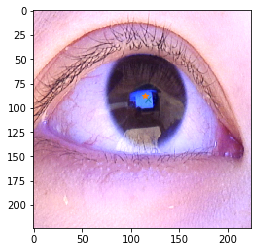

(102.969833,91.882423) - (102.283784,88.698198)(gt): 3.257292


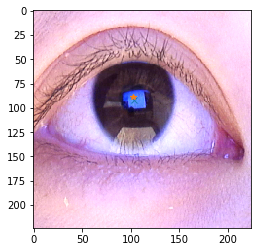

(87.721298,93.232895) - (87.000000,89.458457)(gt): 3.842740


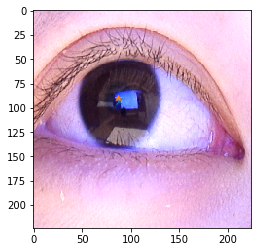

(136.099655,107.889977) - (127.635229,105.126214)(gt): 8.904207


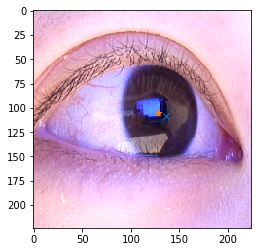

(124.058899,108.591156) - (116.081258,103.315858)(gt): 9.564074


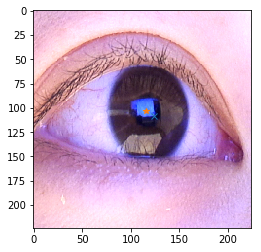

(106.291267,107.373367) - (103.665172,105.000000)(gt): 3.539668


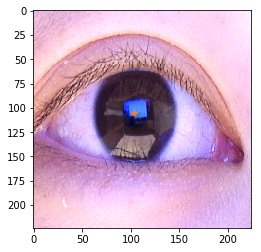

(92.424805,107.149940) - (90.937574,107.691402)(gt): 1.582731


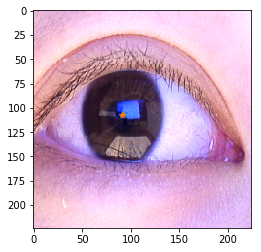

(126.133385,77.524063) - (140.308036,68.640625)(gt): 16.728305


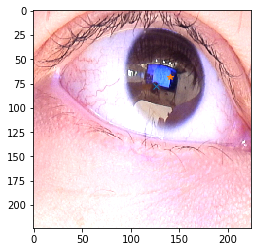

(137.458328,83.947281) - (150.560175,84.892779)(gt): 13.135919


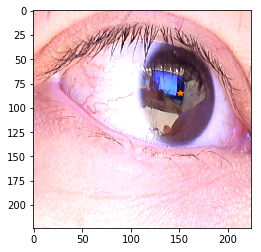

(136.378510,83.942307) - (149.611940,83.985075)(gt): 13.233500


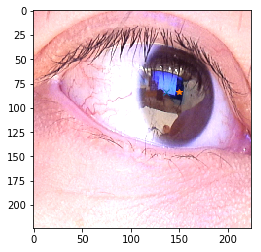

(127.339981,81.172676) - (138.000000,81.130354)(gt): 10.660103


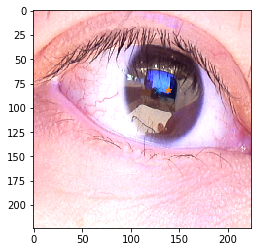

(107.040306,78.034752) - (112.057196,73.042435)(gt): 7.077599


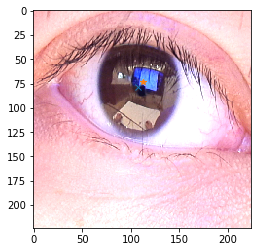

(136.094009,73.848061) - (139.675105,77.860759)(gt): 5.378290


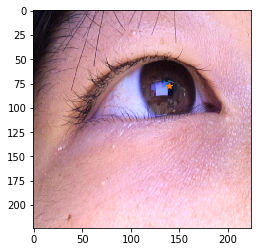

(131.645050,71.311714) - (132.974359,77.974359)(gt): 6.793960


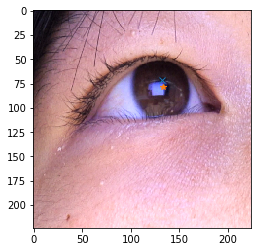

(119.524368,68.887856) - (122.000000,78.070039)(gt): 9.510060


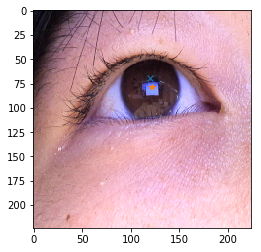

(109.839470,71.227905) - (113.096070,79.109170)(gt): 8.527589


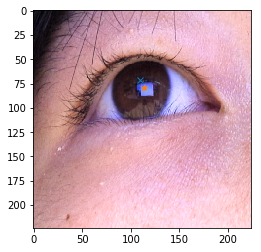

(140.865799,89.153282) - (139.790909,88.386364)(gt): 1.320436


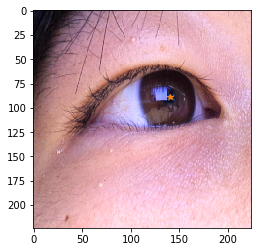

(136.105576,93.465256) - (131.414747,87.110599)(gt): 7.898452


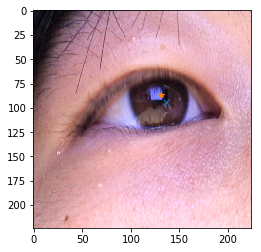

(121.635605,85.342033) - (121.372727,89.000000)(gt): 3.667400


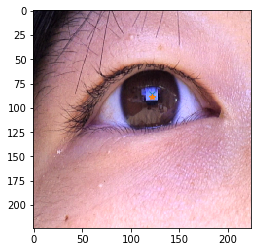

(99.251183,82.859901) - (96.463028,66.950704)(gt): 16.151667


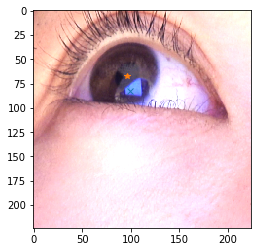

(122.207321,84.826424) - (127.219203,75.623188)(gt): 10.479432


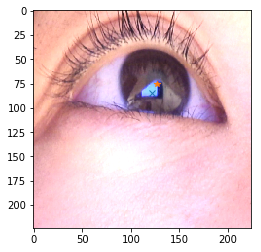

(111.918655,84.748970) - (117.574338,73.179226)(gt): 12.878110


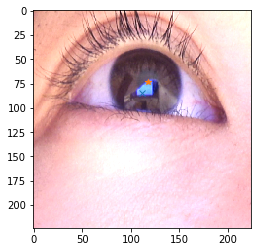

(103.247490,85.695549) - (108.506108,74.427574)(gt): 12.434642


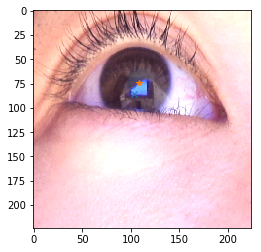

(97.278572,85.768425) - (96.051402,74.028037)(gt): 11.804349


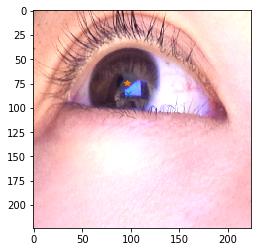

(126.321663,90.666000) - (129.669704,83.419134)(gt): 7.982884


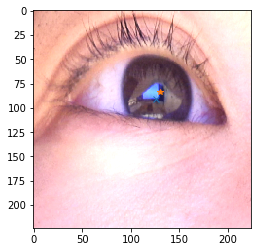

(110.091316,88.320450) - (118.000000,81.089172)(gt): 10.716280


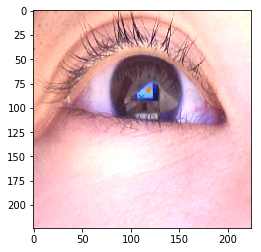

(97.393280,90.041153) - (108.088346,82.140977)(gt): 13.296511


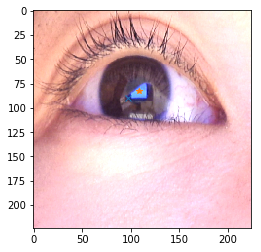

(89.129898,90.466408) - (97.500000,81.500000)(gt): 12.266013


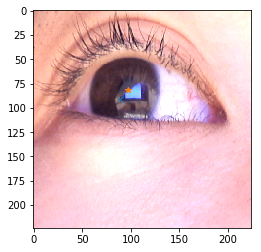

(127.144272,78.160339) - (141.807069,66.434462)(gt): 18.774819


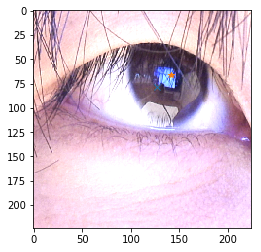

(120.028618,79.044655) - (130.872727,63.043357)(gt): 19.329673


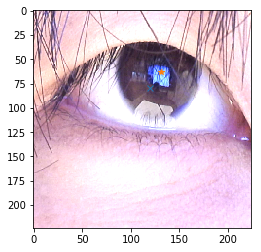

(113.396355,77.945305) - (118.283159,62.046200)(gt): 16.633172


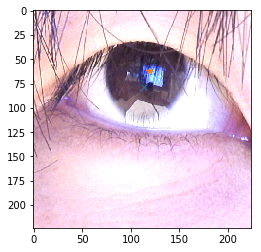

(134.077225,84.907661) - (150.897849,81.209677)(gt): 17.222326


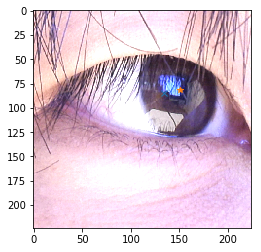

(130.090393,83.659676) - (140.627246,80.000000)(gt): 11.154303


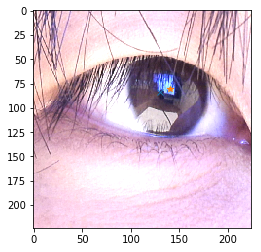

(121.685463,83.449364) - (127.925373,77.329851)(gt): 8.739847


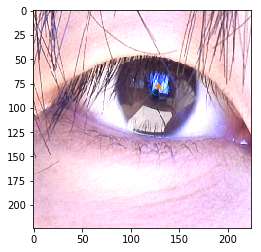

(112.179306,83.108086) - (114.671988,76.979681)(gt): 6.615951


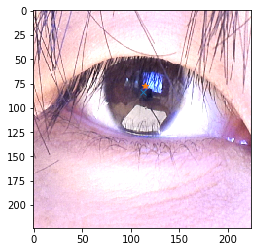

(123.336807,71.654984) - (129.596685,75.569061)(gt): 7.382823


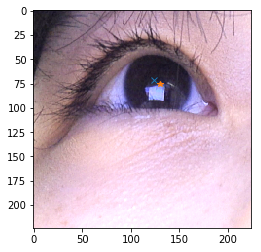

(122.125847,72.937004) - (129.592965,76.899497)(gt): 8.453355


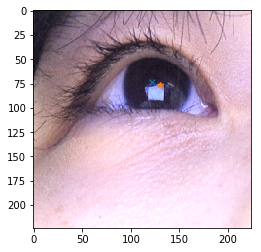

(108.635719,78.068611) - (110.859551,78.685393)(gt): 2.307779


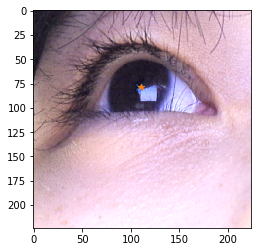

(107.491516,78.282089) - (107.228346,78.645669)(gt): 0.448830


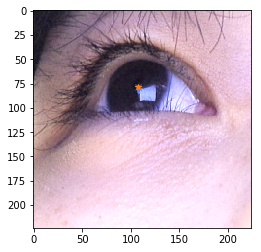

(130.544586,79.704308) - (139.664430,84.812081)(gt): 10.452793


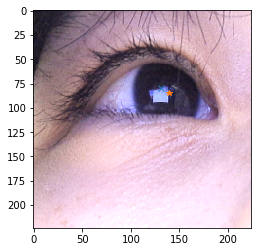

(106.581612,88.357422) - (108.490323,88.845161)(gt): 1.970042


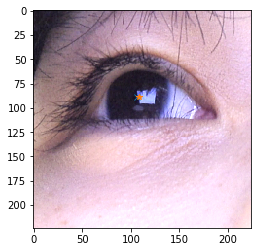

(143.675339,109.751961) - (145.981675,116.175393)(gt): 6.824930


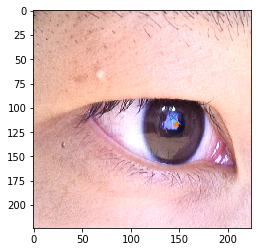

(129.584274,106.451942) - (135.620588,114.944118)(gt): 10.418931


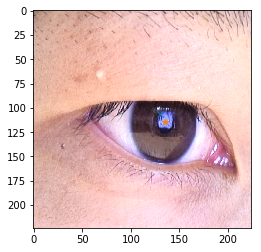

(118.693085,105.818954) - (127.110811,113.216216)(gt): 11.206141


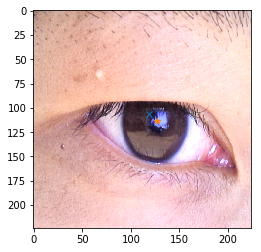

(140.159622,114.495689) - (151.976331,126.136095)(gt): 16.587153


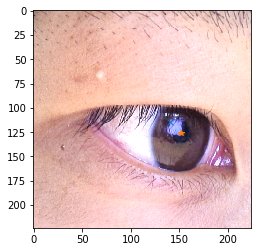

(137.530273,113.950508) - (144.425000,127.500000)(gt): 15.202828


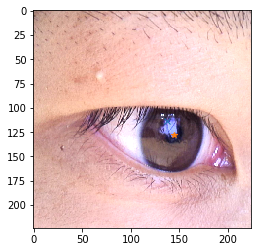

(126.758301,113.587273) - (135.042484,125.683007)(gt): 14.660643


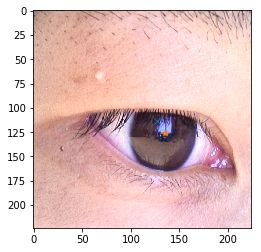

(118.015877,114.438828) - (126.234727,123.688103)(gt): 12.373301


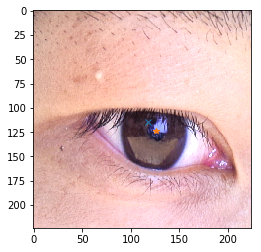

In [20]:
    from PIL import Image
    import matplotlib.pyplot as plt

    n = 0

    for i in range(len(fpaths_xs_test)):
        # テスト画像
        im1 = Image.open(fpaths_xs_test[i])
        im1 = im1.resize(target_size) 

        # Show pupil prediction
        print('(%f,%f) - (%f,%f)(gt): %f'%(outputs[i,0],outputs[i,1],
                                           center_test[i,0],center_test[i,1],
                                           np.linalg.norm(diff[i,:])))
        plt.imshow(im1)
        plt.plot(outputs[i,0], outputs[i,1],'x')
        plt.plot(center_test[i,0], center_test[i,1], '*')
        plt.show()

        n = n + 1

In [ ]:
#
#   Show History
#
mode = 'SHOW_HISTORY'
if mode == "SHOW_HISTORY":
    # load pickle
    print(dname_checkpoints + '/' + fname_history)
    history = pickle.load(open(dname_checkpoints + '/' + fname_history, 'rb'))
    
    for k in history.keys():
        plt.plot(history[k])
        plt.title(k)
        plt.show()
